<h1 align="center"> Lending Club Loan Analysis & Classification </h1>
<h2 align="right"> Jim Chung </h2>

## What is Lending Club?

<a src="https://en.wikipedia.org/wiki/Lending_Club"> Lending Club </a>
 is a  peer to peer lending company based in the United States, in which investors provide funds for potential borrowers and investors earn a profit depending on the risk they take (the borrowers credit score). Lending Club provides the "bridge" between investors and borrowers. For more basic information about the company please check out the wikipedia article about the company. 


## Data Descriptions:

These files contain complete loan data for all loans issued through the 2007-2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. 

## Table of Contents:

1. <b>Introduction</b><br>
a) [General Information](#general_information)<br><br>

2. <b>Exploratory Data Analysis</b><br>
a) [Stochastic Distribution](#dist)<br>
b) [Loan Issurance by Year, Region, and Income](#by_factors)<br><br>

3. <b>Default Classification</b><br>
a) [Feature Engineering](#risky_side)<br>
b) [Missing Values](#missing)<br>
b) [Grid Search & Random Search](#credit_scores)<br>
c) [Determinants of a bad loan](#determines_bad_loan)<br>
d) [Evaluation](#defaulted_loans)

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data Handling
import pandas as pd
import numpy as np
import seaborn as sns

# Modeling
from sklearn import ensemble
from sklearn.preprocessing import OneHotEncoder, Imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from xgboost import XGBClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Test
import scipy.stats as stats

# Iteration Helper
from tqdm import tqdm
import itertools

%matplotlib inline

df = pd.read_csv("~/data/school/DA/loan.csv")
print("rows: {}, columns: {}".format(df.shape[0], df.shape[1]))

rows: 887379, columns: 74


<br>
<br>
<a id="general_information"></a>
# Introduction

## General Information

The file is a matrix of about 890 thousand observations and 74 variables. The existance of missing values makes it important to apply data cleaning and feature engineering. I will suggest useful insights by visualization in the following chapter. Then, careful engineering will be applied to build a prediction for classifying bad loans.



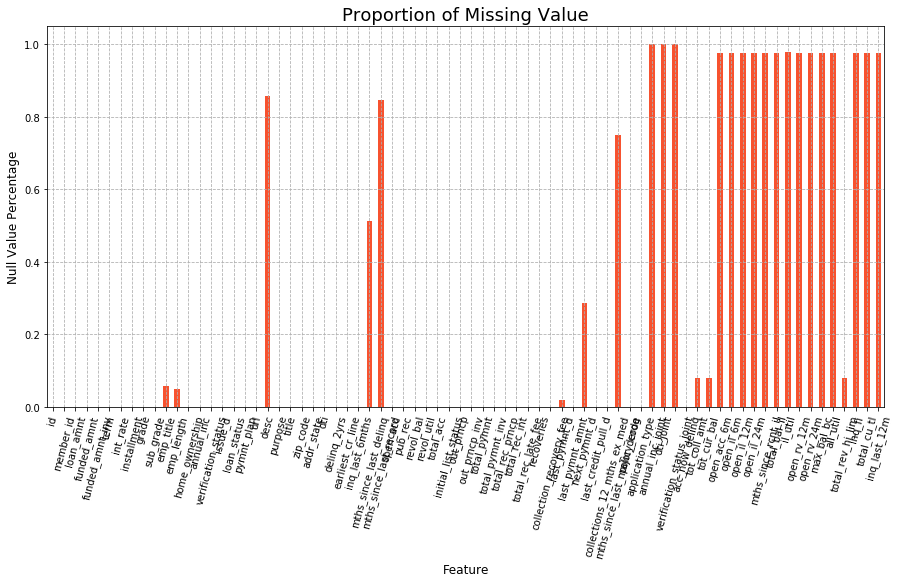

In [2]:
def nullity_plot(df, rot=75, figsize=(15, 7), color="#F7522F"):
    ax = (df.isnull().sum()/df.shape[0]).plot(kind='bar', figsize=figsize, color=color, rot=rot)
    plt.grid(True, linestyle='--')
    ax.set_xlabel("Feature", fontsize=12)
    ax.set_ylabel("Null Value Percentage", fontsize=12)
    ax.set_title('Proportion of Missing Value', fontsize=18)
    
nullity_plot(df)

In [3]:
# Rename features
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount",\
                        "funded_amnt_inv": "investor_funds", "last_pymnt_amnt":"last_pymnt_amount",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

# relevant columns for further analysis
col = 'loan_amount,funded_amount,emp_length,home_ownership,interest_rate,\
annual_income,last_pymnt_amount,total_pymnt,loan_status,dti'.split(',')

ori_df = df.copy()
df = df[col]

# We are interested in 'loan status' variable
list(df.loan_status.unique())

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Issued']

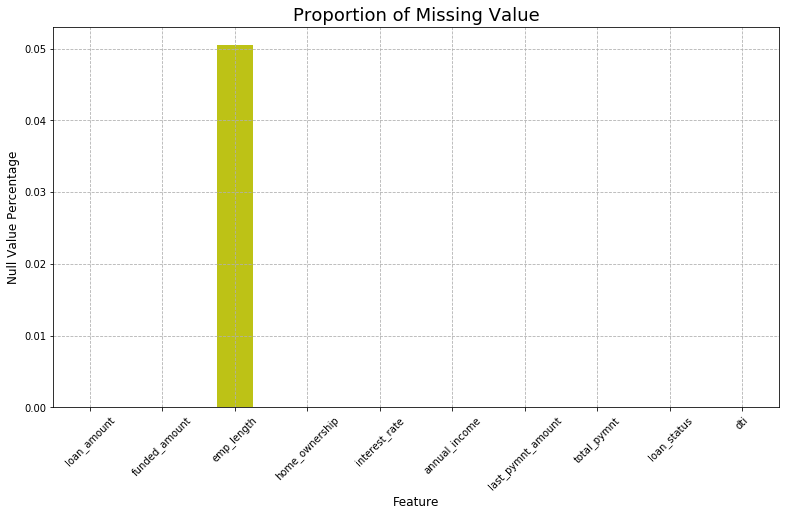

In [4]:
# See selected features have no or small number of missing values
nullity_plot(df, rot=45, figsize=(13,7), color="#BDC216")

Selected 8 features are as follows:

1. **loan_amount**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
2. **funded_amount**: The total amount committed to that loan at that point in time.
3. **emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
4. **home_ownership**: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
5. **annual_income**: The self-reported annual income provided by the borrower during registration.
6. **last_pymnt_amount**: Last total payment amount received.
7. **total_pymnt**: Payments received to date for total amount funded.<br>
8. **dti**: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
9. **loan_status**: Current status of the loan.
    + 'Fully Paid'
    + 'Charged Off'
    + 'Current',
    + 'Default',
    + 'Late (31-120 days)',
    + 'In Grace Period',
    + 'Late (16-30 days)',
    + 'Does not meet the credit policy. Status:Fully Paid',
    + 'Does not meet the credit policy. Status:Charged Off',
    + 'Issued'

These variables have no or a small amount of missing values. Also, they are highly likely to be relavant to 'loan_status.'

<br>
<br>

# Exploratory Data Analysis

### Things to see
- Non-normality
- Number of loan issurances over time
- Who borrow the loan?
- Indicators of bad loans

<a id="dist"></a>
## Stochastic Distribution

You will see the distribution of the loan amount is not well normally distributed. This seems reasonable considering the fact that people with low income will tend to borrow more than the rich. Plus, the interest rate of lending club is higher than that of banks. Large business loans would have been borrowed from other financial institutions.


Text(0.5,1,'Total committed by Investors')

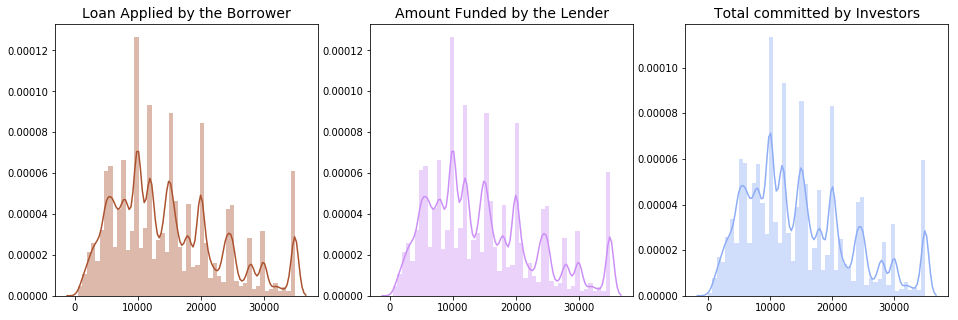

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = df["loan_amount"].values
funded_amount = df["funded_amount"].values
investor_funds = ori_df["investor_funds"].values

sns.distplot(loan_amount, ax=ax[0], color="#AB522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#CC8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#8EADF6")
ax[2].set_title("Total committed by Investors", fontsize=14)

<b>QQ plot</b> is a graphical method for comparing two probability distributions by plotting their quantiles against each other. In this case, this plot shows if the values of the loan amount are normally distributed.

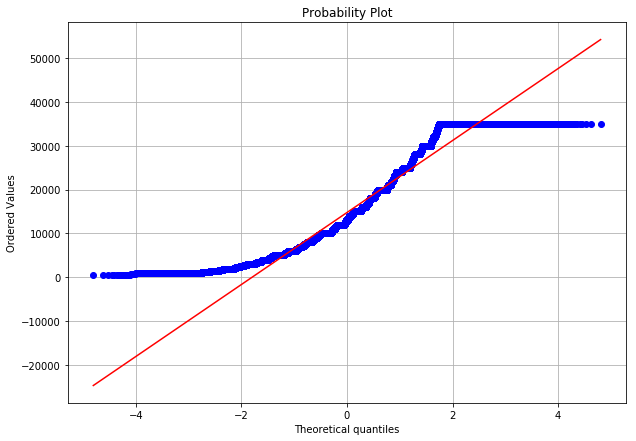

In [6]:
# Graph shows non-normality
def call_qqplot(data):

    plt.style.use('seaborn-bright')
    plt.figure(figsize=(10,7))
    ax = stats.probplot(data, dist="norm", plot=plt)
    plt.grid(True)

call_qqplot(loan_amount)

<b>Non-normality Problem:</b><br>

- Spurious Interactions
- Model Bias

Non-normality affects further analysis in various ways. If you are performing a regression or a design of experiments (any statistical modelling), this asymmetrical behavior may lead to a bias in the model.

<b>Solutions</b>:<br>

- Log Transformation
- Box-Cox Transformation
- others

Log transformation is useful in particular when the data has a skewed distribution. Based on the histograms, the distribution has skewness.

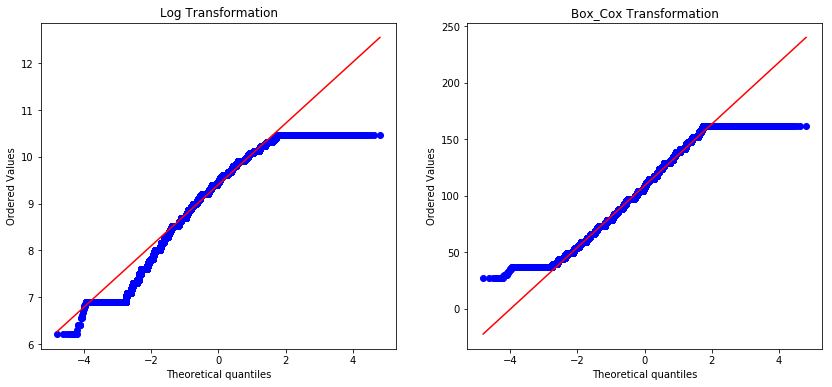

In [7]:
plt.figure(figsize=(14,6))

# Log Transformation
ax1 = plt.subplot(121)
log_trans = np.log(loan_amount)
res = stats.probplot(log_trans, plot=plt)
ax1.set_title("Log Transformation")

# Box-Cox
ax2 = plt.subplot(122)
box_cox, _ = stats.boxcox(loan_amount)
res = stats.probplot(box_cox, plot=plt)
ax2.set_title("Box_Cox Transformation")

plt.show()

The transformation alomost fixed the non-normality of the data. In order to perform any parametric statistical anaylsis, this transformed data will be useful.

<br>
<br>
<a id="by_factors"></a>
## Loan Issued by Year, Region, and Income

This analysis is important for multiple purposes. First, it gives us a good sense of the underlying trends. 

### 1. Year

In [8]:
# Transform the issue dates by year.
ori_df['issue_d'].head()
dt_series = pd.to_datetime(ori_df['issue_d'])
df['year'] = dt_series.dt.year

Text(0,0.5,'Average Amount of Loans Issued')

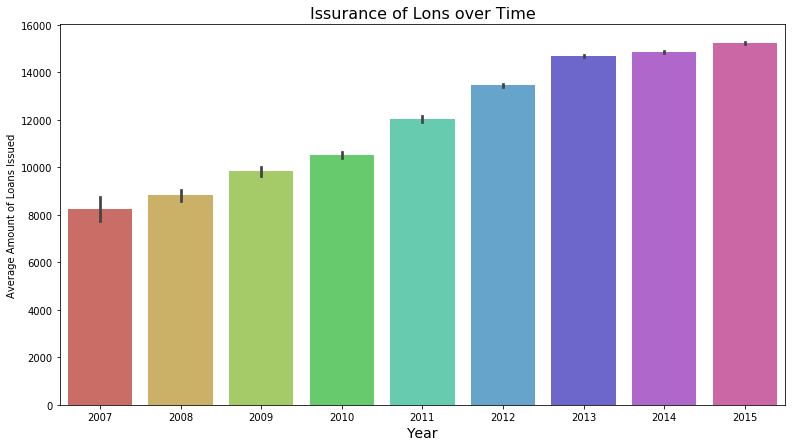

In [9]:
# Loan amounts along year.
# See the constant increasing pattern. This is attributed to low interate rate from fiancial crisis
# Also, the economy is recovering from the crisis
plt.figure(figsize=(13, 7))
sns.barplot('year', 'loan_amount', data=df, palette='hls')
plt.title('Issurance of Lons over Time', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Amount of Loans Issued')

<br>
<br>
### 2. Region

In [10]:
# Over Regions
ori_df['addr_state'].head()

0    AZ
1    GA
2    IL
3    CA
4    OR
Name: addr_state, dtype: object

In [11]:
# State Dictionary
state = pd.read_csv("stateDict.csv")
state.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


In [12]:
state_dict = dict(zip(state['State Code'], state['Division']))
df["region"] = ori_df['addr_state'].map(state_dict)
df.head()

,loan_amount,funded_amount,emp_length,home_ownership,interest_rate,annual_income,last_pymnt_amount,total_pymnt,loan_status,dti,year,region
0,5000.0,5000.0,10+ years,RENT,10.65,24000.0,171.62,5861.071414,Fully Paid,27.65,2011,Mountain
1,2500.0,2500.0,< 1 year,RENT,15.27,30000.0,119.66,1008.710000,Charged Off,1.00,2011,South Atlantic
2,2400.0,2400.0,10+ years,RENT,15.96,12252.0,649.91,3003.653644,Fully Paid,8.72,2011,East North Central
3,10000.0,10000.0,10+ years,RENT,13.49,49200.0,357.48,12226.302212,Fully Paid,20.00,2011,Pacific
4,3000.0,3000.0,1 year,RENT,12.69,80000.0,67.79,3242.170000,Current,17.94,2011,Pacific


In [13]:
ori_df['complete_date'] = pd.to_datetime(ori_df['issue_d'])
ori_df['region'] = df['region']

group_dates = ori_df.groupby(['complete_date', 'region'], as_index=False).sum()

group_dates['issue_d'] = [month.to_period('M') for 
                          month in group_dates['complete_date']]

group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates = group_dates.groupby(['issue_d', 'region'], as_index=False).sum()
group_dates['loan_amount'] = group_dates['loan_amount']/1000


df_dates = pd.DataFrame(data=group_dates[['issue_d','region','loan_amount']])

Text(0.5,1,'Loans issued by Region')

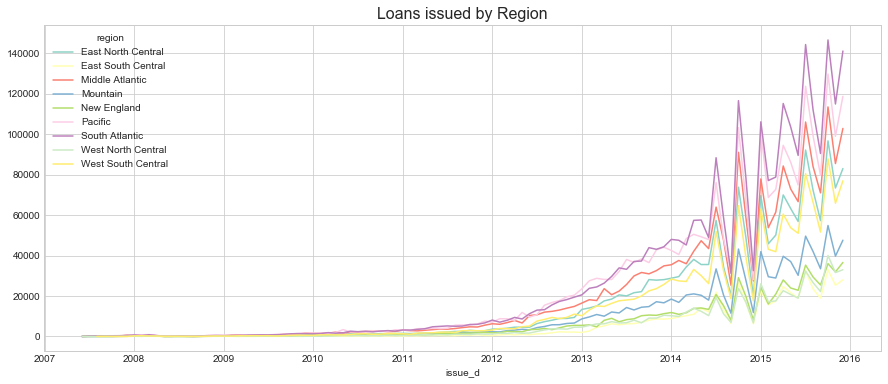

In [14]:
df_dates['complete_date'] = ori_df['issue_d']

plt.style.use('seaborn-whitegrid')
cmap = plt.cm.Set3

by_issued_amount = df_dates.groupby(['issue_d', 'region']).loan_amount.sum()
by_issued_amount.unstack().plot(stacked=False, colormap=cmap, grid=True, legend=True, figsize=(15,6))

plt.title('Loans issued by Region', fontsize=16)

![regions](./regions_us.png)

According to the boxplot, the movements of loan amounts are similar across the regions. This observation is different from my expectation that they may vary largely in regions. Aside from the increasing trend, the seasonal fluctuations tend to synchronize over the regions.
<br>
<br>
<b>Next question:</b>
- How about loan conditions across regions?

In [15]:
# What is loan status?
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [16]:
# Let`s divide the status into binary category: good or bad
bad_loans = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]
good_loans = [status for status in df['loan_status'].unique() if status not in bad_loans]

# make a dictionary for transformation- bad:1, good:0
mapping = dict(zip(bad_loans + good_loans, [1]*len(bad_loans) + [0]*len(good_loans)))

# Mapping Transform
df['loan_condition'] = df['loan_status'].map(mapping)
df.head()

,loan_amount,funded_amount,emp_length,home_ownership,interest_rate,annual_income,last_pymnt_amount,total_pymnt,loan_status,dti,year,region,loan_condition
0,5000.0,5000.0,10+ years,RENT,10.65,24000.0,171.62,5861.071414,Fully Paid,27.65,2011,Mountain,0
1,2500.0,2500.0,< 1 year,RENT,15.27,30000.0,119.66,1008.710000,Charged Off,1.00,2011,South Atlantic,1
2,2400.0,2400.0,10+ years,RENT,15.96,12252.0,649.91,3003.653644,Fully Paid,8.72,2011,East North Central,0
3,10000.0,10000.0,10+ years,RENT,13.49,49200.0,357.48,12226.302212,Fully Paid,20.00,2011,Pacific,0
4,3000.0,3000.0,1 year,RENT,12.69,80000.0,67.79,3242.170000,Current,17.94,2011,Pacific,0


Text(0.5,1,'Proportion of Good Loans by Region')

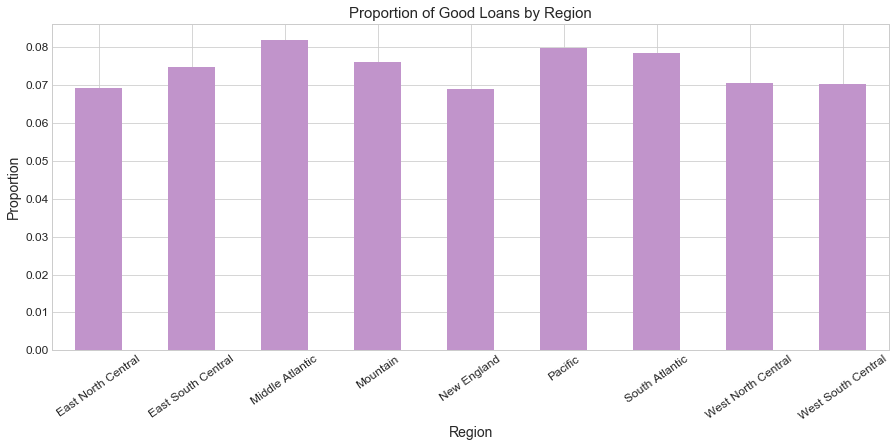

In [17]:
prop_good_loan = df.groupby('region')['loan_condition'].sum()/df.groupby('region')['loan_condition'].size()
ax = prop_good_loan.plot(kind='bar', figsize=(15,6), fontsize=12, rot=35, grid=True, color="#C194CB")
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xlabel("Region", fontsize=14)
plt.title('Proportion of Good Loans by Region', fontsize=15)

Again, there is no clear differene in the proportions of good loans among regions. It is required to apply pair-wise two sample t-tests or ANOVA test in order to figure the statistical significance. From a practical point of view, region variable does not hold much information about the loan quality and amount.

<br>
<br>
### 3. Income

**What we need to know:** <br>
<ul>
<li><b>Low income category:</b> Borrowers that have an annual income lower or equal to 100,000 usd.</li>
<li> <b> Medium income category:</b> Borrowers that have an annual income higher than 100,000 usd but lower or equal to 200,000 usd. </li>
<li><b> High income category: </b> Borrowers that have an annual income higher tha 200,000 usd. </li>

In [18]:
df['income_level'] = np.nan

df.loc[df['annual_income'] <= 100000 ,'income_level'] = "low"
df.loc[(df['annual_income'] > 100000) & (df['annual_income'] <= 200000) ,'income_level'] = "mid"
df.loc[df['annual_income'] > 200000 ,'income_level'] = "high"

df.head()

,loan_amount,funded_amount,emp_length,home_ownership,interest_rate,annual_income,last_pymnt_amount,total_pymnt,loan_status,dti,year,region,loan_condition,income_level
0,5000.0,5000.0,10+ years,RENT,10.65,24000.0,171.62,5861.071414,Fully Paid,27.65,2011,Mountain,0,low
1,2500.0,2500.0,< 1 year,RENT,15.27,30000.0,119.66,1008.710000,Charged Off,1.00,2011,South Atlantic,1,low
2,2400.0,2400.0,10+ years,RENT,15.96,12252.0,649.91,3003.653644,Fully Paid,8.72,2011,East North Central,0,low
3,10000.0,10000.0,10+ years,RENT,13.49,49200.0,357.48,12226.302212,Fully Paid,20.00,2011,Pacific,0,low
4,3000.0,3000.0,1 year,RENT,12.69,80000.0,67.79,3242.170000,Current,17.94,2011,Pacific,0,low


In [19]:
# Those with low level income are most of the customers
df.income_level.value_counts()

low     729612
mid     140977
high     16786
Name: income_level, dtype: int64

In [20]:
df.groupby('income_level')['loan_condition'].sum()

income_level
high      808
low     58865
mid      7756
Name: loan_condition, dtype: int64

In [21]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

# Create a new column and convert emp_length to integers.

lst = [df]
df['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"] = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"] = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"] = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"] = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"] = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"] = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"] = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"] = 2
    col.loc[col['emp_length'] == '1 year', "emp_length_int"] = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"] = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"] = 0

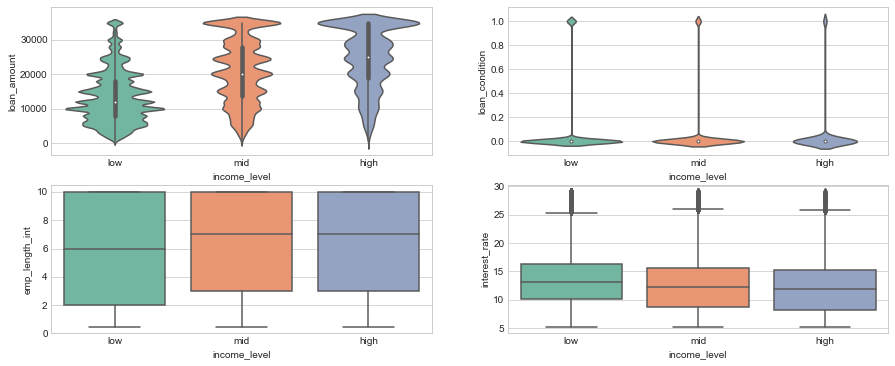

In [22]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(15,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_level", y="loan_amount", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_level", y="loan_condition", data=df, palette="Set2", ax=ax2)
sns.boxplot(x="income_level", y="emp_length_int", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_level", y="interest_rate", data=df, palette="Set2", ax=ax4)

plt.show()

<br>
<br>
# Defualt Classification

## Feature Engineering
<br>
**Objective**: 

Machine learning algorithms alone cannot process those data other than numerical features. For example, 'emp_length' column has 12 values such as '10+ years' or '1 year.' This information should be converted into a numerical form before we take into any machine learning algorithms. 'emp_length_int' is the result of the transformation. Textual parts were removed and numeric values are added, e.g., 10 for '10+ years' and 1 for '1 year.' I will not only clean up the features, but also create new features from the existing ones to enhance my prediction performance.

In [23]:
df.home_ownership.unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [24]:
df.head()

,loan_amount,funded_amount,emp_length,home_ownership,interest_rate,annual_income,last_pymnt_amount,total_pymnt,loan_status,dti,year,region,loan_condition,income_level,emp_length_int
0,5000.0,5000.0,10+ years,RENT,10.65,24000.0,171.62,5861.071414,Fully Paid,27.65,2011,Mountain,0,low,10.0
1,2500.0,2500.0,< 1 year,RENT,15.27,30000.0,119.66,1008.710000,Charged Off,1.00,2011,South Atlantic,1,low,0.5
2,2400.0,2400.0,10+ years,RENT,15.96,12252.0,649.91,3003.653644,Fully Paid,8.72,2011,East North Central,0,low,10.0
3,10000.0,10000.0,10+ years,RENT,13.49,49200.0,357.48,12226.302212,Fully Paid,20.00,2011,Pacific,0,low,10.0
4,3000.0,3000.0,1 year,RENT,12.69,80000.0,67.79,3242.170000,Current,17.94,2011,Pacific,0,low,1.0


In [25]:
# Redundant variables dropped
df = df.drop(['emp_length', 'loan_status', 'region'], axis=1)

In [26]:
# Income Level into integers
df['income_level_int'] = df['income_level'].factorize()[0]
df = df.drop(['income_level'], axis=1)

In [27]:
df['home_ownership'].map(mapping).factorize()

(array([-1, -1, -1, ..., -1, -1, -1]), Float64Index([], dtype='float64'))

In [28]:
# Home Ownership
mapping = {'OWN' : 'OWNED', 'MORTGAGE' : 'OWNED', 'RENT' : 'NONE', 'OTHER' : 'NONE',
           'ANY' : 'NONE'}
df['home_ownership'] = df['home_ownership'].map(mapping).factorize()[0]

In [29]:
df.head()

,loan_amount,funded_amount,home_ownership,interest_rate,annual_income,last_pymnt_amount,total_pymnt,dti,year,loan_condition,emp_length_int,income_level_int
0,5000.0,5000.0,0,10.65,24000.0,171.62,5861.071414,27.65,2011,0,10.0,0
1,2500.0,2500.0,0,15.27,30000.0,119.66,1008.710000,1.00,2011,1,0.5,0
2,2400.0,2400.0,0,15.96,12252.0,649.91,3003.653644,8.72,2011,0,10.0,0
3,10000.0,10000.0,0,13.49,49200.0,357.48,12226.302212,20.00,2011,0,10.0,0
4,3000.0,3000.0,0,12.69,80000.0,67.79,3242.170000,17.94,2011,0,1.0,0


<br>
### Missing Values <a id='2.2'></a>

Most machine learning algorithms cannot handle the problem of missing values intrinsically. KNN is a notable exception, but the others are still designed for complete data. There are several ways to deal with this.

+ There are two broad classes of missing data: data missing at random, and data missing not at random. When considering what to do with our data we must keep this in mind. http://www.residentmar.io/2016/06/12/null-and-missing-data-python.html. The typology of the missing data strongly informs how best to approach dealing with it; or rather it's safer to say that if the data is missing not completely at random, you are going to need domain expertise to understand what to do with it:

+ <a href="https://statisticalhorizons.com/wp-content/uploads/MissingDataByML.pdf">"Handling Missing Data by Maximum Likelihood"</a>, Paul D. Allison

In [30]:
df.isnull().sum()

loan_amount              0
funded_amount            0
home_ownership           0
interest_rate            0
annual_income            4
last_pymnt_amount        0
total_pymnt              0
dti                      0
year                     0
loan_condition           0
emp_length_int       44825
income_level_int         0
dtype: int64

### Solutions
#### 1. Dropping rows with null values

#### 2. Dropping features with high nullity
One of the most frequently considered methods is to drop the feature with high nullity. It is difficult to leverage the features with many null points for further analyses. This can even decrease the overall validity of our model&testing leading to the wrong conclusion. In our case, the features do not have too high proportion of null points.

#### 3. Simple imputation

Rather than excluding the rows or columns with missing values, we can simply replace the null points with the median o r mean of the columns. Again, this imputation needs a careful approach as the missing values should be missing at random for the imputation to be unbiased. It seems quite reasonable to apply this technique as the given dataset shows no significant trend.

#### 4. Model imputation
Finally, here is a trick. We can build a model to fix missing values so that the values can be used again for another machine learning model. The columns with missing data become the target variable and existing data are taken in as predictor variables. I will try to build a regression model to apply this approach. The statistical implication underlying this method is to decrease the bias using predictive models.

In [31]:
# In our case, the number of null values is marginal. (~5%)
# I will drop the rows rather than introducing more noise
df = df.dropna(how='any')
df.shape

(842550, 12)

In [32]:
df.head()

,loan_amount,funded_amount,home_ownership,interest_rate,annual_income,last_pymnt_amount,total_pymnt,dti,year,loan_condition,emp_length_int,income_level_int
0,5000.0,5000.0,0,10.65,24000.0,171.62,5861.071414,27.65,2011,0,10.0,0
1,2500.0,2500.0,0,15.27,30000.0,119.66,1008.710000,1.00,2011,1,0.5,0
2,2400.0,2400.0,0,15.96,12252.0,649.91,3003.653644,8.72,2011,0,10.0,0
3,10000.0,10000.0,0,13.49,49200.0,357.48,12226.302212,20.00,2011,0,10.0,0
4,3000.0,3000.0,0,12.69,80000.0,67.79,3242.170000,17.94,2011,0,1.0,0


In [33]:
X = df.drop('loan_condition', axis=1)
y = df['loan_condition']

# Test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<br>
### Grid Search & Random Search

The randomized search and the grid search explore exactly the same space of parameters. The result in parameter settings is quite similar, while the run time for randomized search is drastically lower.

The performance is slightly worse for the randomized search, though this is most likely a noise effect and would not carry over to a held-out test set.

### Random Forest

In [34]:
# Grid search to find the optimal parameters
param_grid = [
    {'n_estimators': [10, 30], 'max_features': [2, 4, 6]}
]

# Fit random forests
clf = ensemble.RandomForestClassifier()
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=scorer)

# Fit the data
grid_search.fit(X_train, y_train)

# Metrics
cvres = grid_search.cv_results_
for acc, params in zip(cvres['mean_test_score'], cvres['params']):
    print("test accuracy: {},".format(acc), "parameters: ", params)

test accuracy: 0.9563542223013471, parameters:  {'max_features': 2, 'n_estimators': 10}
test accuracy: 0.9592056851225447, parameters:  {'max_features': 2, 'n_estimators': 30}
test accuracy: 0.9630867604296481, parameters:  {'max_features': 4, 'n_estimators': 10}
test accuracy: 0.9643670998753783, parameters:  {'max_features': 4, 'n_estimators': 30}
test accuracy: 0.9645822206397247, parameters:  {'max_features': 6, 'n_estimators': 10}
test accuracy: 0.9654530888374577, parameters:  {'max_features': 6, 'n_estimators': 30}


In [35]:
def plot_confusion_mat(cm, classes, cmap=plt.cm.Blues):
    title='Confusion matrix'

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def full_report(model, x, y_true, classes):
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(x)
    y_true = y_true

    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true, y_pred)))
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    #print(cnf_matrix)
    plot_confusion_mat(cnf_matrix, classes=classes)    

Accuracy : 0.9656340869978043
Classification Report
              precision    recall  f1-score   support

           0     0.9661    0.9979    0.9817    155766
           1     0.9568    0.5714    0.7155     12744

   micro avg     0.9656    0.9656    0.9656    168510
   macro avg     0.9614    0.7846    0.8486    168510
weighted avg     0.9654    0.9656    0.9616    168510



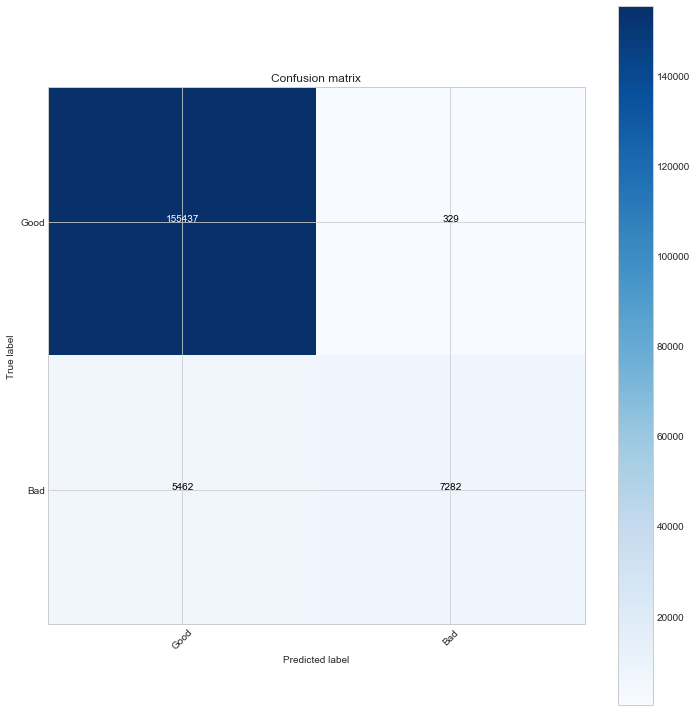

In [38]:
clf_rf = grid_search.best_estimator_
full_report(clf_rf, X_test, y_test, ['Good', 'Bad'])

Text(0,0.5,'Importance')

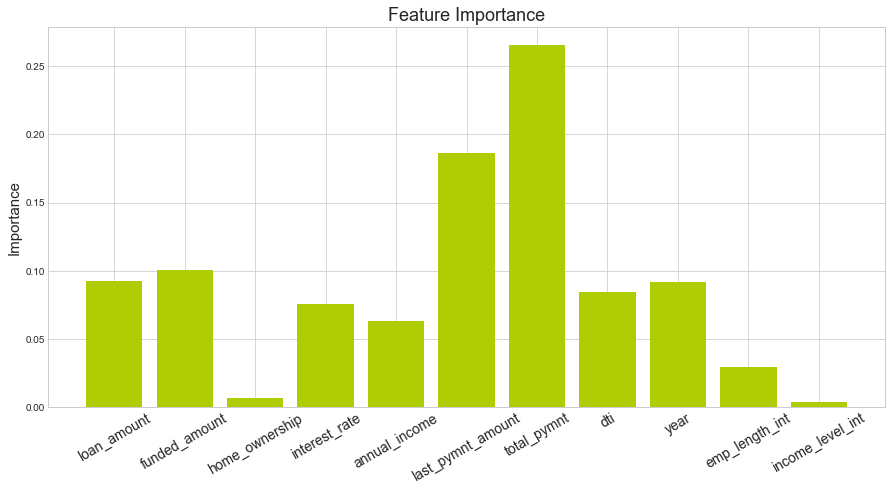

In [46]:
plt.figure(figsize=(15,7))
plt.bar(range(X_train.shape[1]), clf_rf.feature_importances_, color="#AFCC05")
plt.xticks(range(X_train.shape[1]), list(X_train.columns), fontsize=14, rotation=30)
plt.title("Feature Importance", fontsize=18)
plt.ylabel("Importance", fontsize=15)

<br>
### XGBoosing

In [47]:
# Grid search to find the optimal parameters
param_grid = [
    {'learning_rate': [0.1, 0.2, 0.3],  'max_depth': [2, 3, 4]}
]

# Fit random forests
clf = XGBClassifier()
scorer = make_scorer(accuracy_score)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring=scorer)

# Fit the data
grid_search.fit(X_train, y_train)

# Metrics
cvres = grid_search.cv_results_
for acc, params in zip(cvres['mean_test_score'], cvres['params']):
    print("test accuracy: {},".format(acc), "parameters: ", params)
    
clf_xg = grid_search.best_estimator_

test accuracy: 0.9336523055011572, parameters:  {'learning_rate': 0.1, 'max_depth': 2}
test accuracy: 0.945884517239333, parameters:  {'learning_rate': 0.1, 'max_depth': 3}
test accuracy: 0.952622989733547, parameters:  {'learning_rate': 0.1, 'max_depth': 4}
test accuracy: 0.9439335944454335, parameters:  {'learning_rate': 0.2, 'max_depth': 2}
test accuracy: 0.9542727434573616, parameters:  {'learning_rate': 0.2, 'max_depth': 3}
test accuracy: 0.9596092220046288, parameters:  {'learning_rate': 0.2, 'max_depth': 4}
test accuracy: 0.9493294166518308, parameters:  {'learning_rate': 0.3, 'max_depth': 2}
test accuracy: 0.9574268589401222, parameters:  {'learning_rate': 0.3, 'max_depth': 3}
test accuracy: 0.9619013708385259, parameters:  {'learning_rate': 0.3, 'max_depth': 4}


<br>
### ROC Curve - Classifier Comparison

ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes.

**Reference**: <a src="https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5"> Understanding AUC - ROC Curve <a>

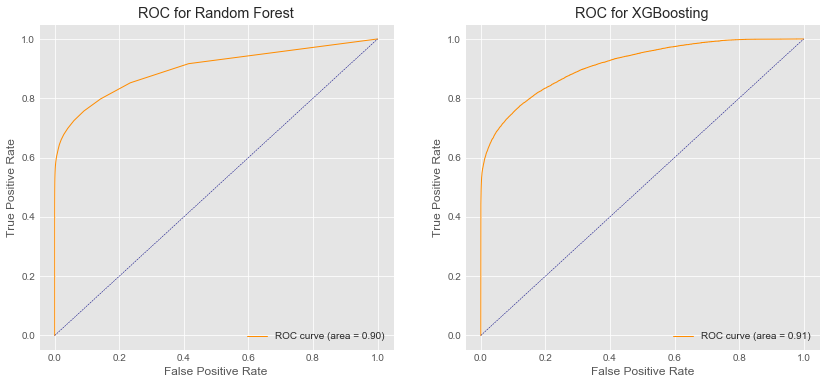

In [50]:
rf_prob = clf_rf.predict_proba(X_test)
xg_prob = clf_xg.predict_proba(X_test)

fpr_rf, tpr_rf, thresholds = roc_curve(y_test, rf_prob[:, 1])
fpr_xg, tpr_xg, thresholds = roc_curve(y_test, xg_prob[:, 1])

auc_rf = auc(fpr_rf, tpr_rf)
auc_xg = auc(fpr_xg, tpr_xg)

plt.style.use('ggplot')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
ax1.plot(fpr_rf, tpr_rf, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % auc_rf)
ax1.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC for Random Forest')
ax1.legend(loc="lower right")

ax2.plot(fpr_xg, tpr_xg, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % auc_xg)
ax2.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC for XGBoosting')
ax2.legend(loc="lower right")

# ROC curve for each classifier
plt.show()